# CS109a - Spotify Project - Scratch notebook

In [2]:
# imports
import os
import sys
import json
import time
import pickle

import numpy as np
import pandas as pd
from scipy import stats

from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sqlalchemy as db
from sqlalchemy import Table, Column, Integer, String, MetaData, and_, or_, func,distinct
from sqlalchemy import create_engine
import sqlite3
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base 

import importlib

from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator

%env SPOTIFY_CLIENT_ID=aff9ad651d0b4181a541bc73c6852474
%env SPOTIFY_CLIENT_SECRET=258c115477814b09b93b0b04d507e929
%env SPOTIFY_REDIRECT_URI=FinalProjectCS109a://callback

env: SPOTIFY_CLIENT_ID=aff9ad651d0b4181a541bc73c6852474
env: SPOTIFY_CLIENT_SECRET=258c115477814b09b93b0b04d507e929
env: SPOTIFY_REDIRECT_URI=FinalProjectCS109a://callback


## SQLITE DB

In [2]:
# Set database path on local drive
db_path = "../data/spotify_songs.db"

# Get sesion
session = get_session(db_path)

# Get Classes
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

In [3]:
# test
result = display_time(session.query(Tracks).first)
display(result.track_uri)

result = display_time(session.query(Artists).first)
display(result.artist_uri)

Time to Execute: 0.01 seconds


'spotify:track:2d7LPtieXdIYzf7yHPooWd'

Time to Execute: 0.0 seconds


'spotify:artist:3tBUUrQ26CCErBABEw2EXo'

## Basic (CSV) Data read functions

### Spotify Data

In [3]:
''' The staff provided data has filenames 'songs0.csv' through 'songs999.csv'
    This function returns a single dataframe containing the desired CSV files.
    Args:
        1) file_nums:  list ... List of file #s to read (e.g. 0, 1, 2 ... 999); default is to just read 'songs0.csv'
        2) songs_dir:  str  ... Where the songs CSVs reside; default is 'songs/' '''
def read_songs_csv(file_nums: list = [0], songs_dir: str = '../data/songs/') -> pd.core.frame.DataFrame:
    # check for valid input
    if any(i < 0 for i in file_nums) or any(i > 999 for i in file_nums) or len(file_nums) == 0:
        print('ERROR - read_songs_csv: Bad parameters; file numbers are out of bounds, or list is empty')
        return
    
    # put all listed songs CSV #s into a dataframe; adds 1000*i to each pid to ensure uniqueness among files read
    dfs = []
    for i in file_nums:
        df = pd.read_csv(songs_dir + 'songs' + str(i) + '.csv')
        df['pid'] = df['pid'] + (i*1000)
        dfs.append(df)
    
    return pd.concat(dfs)

''' This function takes a DF as produced above, and based on the provided field, generates a space-delimited 
    list of strings per pid for that field. For example, the default will generate a string of track_uris per pid. 
    Strips the URI prefix as well. TODO'''
def gen_corpus_by_pid(df:pd.core.frame.DataFrame, col:str='track_uri', prefix:str='spotify:track:'):
    pids = df['pid'].unique()
    strs = []
    
    for pid in pids:
        next_str = df.loc[df['pid'] == pid][col].str.lstrip(prefix)
        strs.append(next_str.str.cat(sep=' '))
        
    return strs, pids

''' Takes a list of songs and converts them into a single row of a sparse matrix based on a larger list of songs. '''
def convert_songs_to_csr(songs:list, all_songs:list):
    return csr_matrix([x in songs and 1 or 0 for x in all_songs])

''' Returns a list of random songs given a full "vocabulary" of songs. '''
def get_random_songs(all_songs:list, num_songs:int=10) -> list:
    return [all_songs[i] for i in np.random.randint(0, len(all_songs), num_songs)]

# for convenience, constants for reading all files/a random assortment/first 10
ALL_FILES = np.arange(0, 1000, 1) # WARNING: this will take awhile
RANDOM = np.random.randint(0, 1000, 10)
FIRST_10 = np.arange(0, 10, 1)

In [4]:
# Create a DF of the 1st 10 files for testing
test_df = read_songs_csv(FIRST_10)
test_df.head()

pid  pos        artist_name                             track_uri  \
0    0    0      Missy Elliott  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1    0    1     Britney Spears  spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2    0    2            Beyoncé  spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3    0    3  Justin Timberlake  spotify:track:1AWQoqb9bSvzTjaLralEkT   
4    0    4             Shaggy  spotify:track:1lzr43nnXAijIGYnCT8M8H   

                              artist_uri  \
0  spotify:artist:2wIVse2owClT7go1WT98tk   
1  spotify:artist:26dSoYclwsYLMAKD3tpOr4   
2  spotify:artist:6vWDO969PvNqNYHIOW5v0m   
3  spotify:artist:31TPClRtHm23RisEBtV3X7   
4  spotify:artist:5EvFsr3kj42KNv97ZEnqij   

                                   track_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)   
1                                       Toxic   
2                               Crazy In Love   
3                              Rock Your Body   
4                                It Wasn't Me   

                              album_uri  duration_ms  \
0  spotify:album:6vV5UrXcfyQD1wu4Qo2I9K       226863   
1  spotify:album:0z7pVBGOD7HCIB7S8eLkLI       198800   
2  spotify:album:25hVFAxTlDvXbx2X2QkUkE       235933   
3  spotify:album:6QPkyl04rXwTGlGlcYaRoW       267266   
4  spotify:album:6NmFmPX56pcLBOFMhIiKvF       227600   

                                     album_name  
0                                  The Cookbook  
1                                   In The Zone  
2  Dangerously In Love (Alben für die Ewigkeit)  
3                                     Justified  
4                                      Hot Shot

In [5]:
# Generate corpus for track_uris for the test dataframe
TRACK_PREFIX = 'spotify:track:'
corpus, pids = gen_corpus_by_pid(test_df)

display(len(corpus))
display(len(pids))

10000

10000

In [6]:
corpus

['0UaMYEvWZi0ZqiDOoHU3YI 6I9VzXrHxO9rA9A5euc8Ak 0WqIKmW4BTrj3eJFmnCKMv 1AWQoqb9bSvzTjaLralEkT 1lzr43nnXAijIGYnCT8M8H 0XUfyU2QviPAs6bxSpXYG4 68vgtRHr7iZHpzGpon6Jlo 3BxWKCI06eQ5Od8TY2JBeA 7H6ev70Weq6DdpZyyTmUXk 2PpruBYCo4H7WOBJ7Q2EwM 2gam98EZKrF9XuOkU13ApN 4Y45aqo9QMa57rDsAJv40A 1HwpWwa6bnqqRhK8agG4RS 20ORwCJusz4KS2PbTPVNKo 7k6IzwMGpxnRghE7YosnXT 1Bv0Yl01xBDZD4OQP93fyl 4omisSlTk6Dsq2iQD7MA07 7xYnUQigPoIDAMPVK79NEq 6d8A5sAx9TfdeseDvfWNHd 4pmc2AxSEq6g7hPVlJCPyP 215JYyyUnrJ98NK3KEwu6d 0uqPG793dkDDN7sCUJJIVC 19Js5ypV6JKn4DMExHQbGc 1JURww012QnWAw0zZXi6Aa 7DFnq8FYhHMCylykf6ZCxA 1TfAhjzRBWzYZ8IdUV3igl 1Y4ZdPOOgCUhBcKZOrUFiS 6MjljecHzHelUDismyKkba 67T6l4q3zVjC5nZZPXByU8 34ceTg8ChN5HjrqiIYCn9Q 5Q0Nhxo0l2bP3pNjpGJwV1 6GIrIt2M39wEGwjCQjGChX 4E5P1XyAFtrjpiIxkydly4 3H1LCvO3fVsK2HPguhbml0 3uoQULcUWfnt6nc6J7Vgai 2nbClS09zsIAqNkshg6jnp 69ghzc538EQSVon2Gm3wrr 1kusepF3AacIEtUTYrw4GV 7oK9VyNzrYvRFo7nQEYkWN 12qZHAeOyTf93YAWvGDTat 2jFlMILIQzs7lSFudG9lbo 4I2GqMe7L2ccMpUbnDzYLH 5lDriBxJd22IhOH9zTcFrV 2eJ8ij1T3

In [5]:
# build count matrix for playlists vs tracks
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(corpus)

# the vectorizer removes colons and counts "spotify" and "track" as words, so we drop them from the resulting matrix
track_uris = vectorizer.get_feature_names()[ : len(vectorizer.get_feature_names()) - 2]
pl_track_matrix = pl_track_matrix[:, : len(pl_track_matrix_uris)]

# calc cosine similarity matrix
# pl_track_similarities = cosine_similarity(pl_track_matrix)

# fit a nearest neighbors model to the similarity matrix
neighbors_model = NearestNeighbors(metric='cosine')
neighbors_model.fit(pl_track_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [8]:
# Grab a sample set of songs from the 1st playlist just as a test, strip URI prefix
sample_songs = test_df[test_df.pid == 0].track_uri
sample_songs = sample_songs.str.lstrip(TRACK_PREFIX)

# build sparse row for 1st 5 songs, 
test_X = convert_songs_to_csr(sample_songs[:5].str.lower().tolist(), pl_track_matrix_uris)

# updated_matrix = vstack([pl_track_matrix, test_X])

# updated_similarity_matrix = cosine_similarity(updated_matrix)

# display(updated_similarity_matrix[len(updated_similarity_matrix)-1].shape)
# display()

test_neighbors = neighbors_model.kneighbors(test_X, return_distance=False)

test_neighbors

array([[   0, 5665, 4266,  355, 5392]], dtype=int64)

In [13]:
neighbor_pids = [pids[i] for i in test_neighbors]
neighbor_pids

test_df[test_df.pid == neighbor_pids[0][0]]

pid  pos               artist_name                             track_uri  \
0     0    0             Missy Elliott  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1     0    1            Britney Spears  spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2     0    2                   Beyoncé  spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3     0    3         Justin Timberlake  spotify:track:1AWQoqb9bSvzTjaLralEkT   
4     0    4                    Shaggy  spotify:track:1lzr43nnXAijIGYnCT8M8H   
5     0    5                     Usher  spotify:track:0XUfyU2QviPAs6bxSpXYG4   
6     0    6                     Usher  spotify:track:68vgtRHr7iZHpzGpon6Jlo   
7     0    7        The Pussycat Dolls  spotify:track:3BxWKCI06eQ5Od8TY2JBeA   
8     0    8           Destiny's Child  spotify:track:7H6ev70Weq6DdpZyyTmUXk   
9     0    9                   OutKast  spotify:track:2PpruBYCo4H7WOBJ7Q2EwM   
10    0   10             Nelly Furtado  spotify:track:2gam98EZKrF9XuOkU13ApN   
11    0   11           Jesse McCartney  spotify:track:4Y45aqo9QMa57rDsAJv40A   
12    0   12           Jesse McCartney  spotify:track:1HwpWwa6bnqqRhK8agG4RS   
13    0   13           Jesse McCartney  spotify:track:20ORwCJusz4KS2PbTPVNKo   
14    0   14                    Cassie  spotify:track:7k6IzwMGpxnRghE7YosnXT   
15    0   15                   Omarion  spotify:track:1Bv0Yl01xBDZD4OQP93fyl   
16    0   16             Avril Lavigne  spotify:track:4omisSlTk6Dsq2iQD7MA07   
17    0   17               Chris Brown  spotify:track:7xYnUQigPoIDAMPVK79NEq   
18    0   18                   Beyoncé  spotify:track:6d8A5sAx9TfdeseDvfWNHd   
19    0   19           Destiny's Child  spotify:track:4pmc2AxSEq6g7hPVlJCPyP   
20    0   20               Sheryl Crow  spotify:track:215JYyyUnrJ98NK3KEwu6d   
21    0   21       The Black Eyed Peas  spotify:track:0uqPG793dkDDN7sCUJJIVC   
22    0   22          Bowling For Soup  spotify:track:19Js5ypV6JKn4DMExHQbGc   
23    0   23            The Click Five  spotify:track:1JURww012QnWAw0zZXi6Aa   
24    0   24               Chris Brown  spotify:track:7DFnq8FYhHMCylykf6ZCxA   
25    0   25            Jonas Brothers  spotify:track:1TfAhjzRBWzYZ8IdUV3igl   
26    0   26                  Lil Mama  spotify:track:1Y4ZdPOOgCUhBcKZOrUFiS   
27    0   27                   Cascada  spotify:track:6MjljecHzHelUDismyKkba   
28    0   28              Jason Derulo  spotify:track:67T6l4q3zVjC5nZZPXByU8   
29    0   29                     Ne-Yo  spotify:track:34ceTg8ChN5HjrqiIYCn9Q   
30    0   30               Miley Cyrus  spotify:track:5Q0Nhxo0l2bP3pNjpGJwV1   
31    0   31           Boys Like Girls  spotify:track:6GIrIt2M39wEGwjCQjGChX   
32    0   32                      Iyaz  spotify:track:4E5P1XyAFtrjpiIxkydly4   
33    0   33               Chris Brown  spotify:track:3H1LCvO3fVsK2HPguhbml0   
34    0   34                     Kesha  spotify:track:3uoQULcUWfnt6nc6J7Vgai   
35    0   35                     Ne-Yo  spotify:track:2nbClS09zsIAqNkshg6jnp   
36    0   36             Justin Bieber  spotify:track:69ghzc538EQSVon2Gm3wrr   
37    0   37                    M.I.A.  spotify:track:1kusepF3AacIEtUTYrw4GV   
38    0   38               The Killers  spotify:track:7oK9VyNzrYvRFo7nQEYkWN   
39    0   39                 blink-182  spotify:track:12qZHAeOyTf93YAWvGDTat   
40    0   40        The Pussycat Dolls  spotify:track:2jFlMILIQzs7lSFudG9lbo   
41    0   41             Justin Bieber  spotify:track:4I2GqMe7L2ccMpUbnDzYLH   
42    0   42  The All-American Rejects  spotify:track:5lDriBxJd22IhOH9zTcFrV   
43    0   43             Justin Bieber  spotify:track:2eJ8ij1T3cNUKiGdcUvKhy   
44    0   44           Vanessa Carlton  spotify:track:5y69gQtK33qxb8a24ACkCy   
45    0   45                  Cris Cab  spotify:track:1X5WGCrUMuwRFuYU1eAo2I   
46    0   46               Miley Cyrus  spotify:track:3utIAb67sOu0QHxBE88P1M   
47    0   47           Jesse McCartney  spotify:track:3jkdQNkDTxxXtjSO4l0o1H   
48    0   48               Demi Lovato  spotify:track:5c1sfI6wIQEsSUw0xrkFdl   
49  

## Reading data Examples - Spotify

In [11]:
# Read all files to DF in memory
#               ----------- commented out, just an example
#songs_df = read_songs_csv(ALL_FILES)
#songs_df.head()

# Read randomly assorted files

songs_df = read_songs_csv(RANDOM)
songs_df.head()

pid  pos    artist_name                             track_uri  \
0    0    0   Lil Uzi Vert  spotify:track:5wyrQLBbmKdxY6yLNdienj   
1    0    1     Young Thug  spotify:track:4cg1yakyRSIOjxKM2I7J1q   
2    0    2      21 Savage  spotify:track:2kE82JhBcoS7mimFO1SqqX   
3    0    3    Rich Chigga  spotify:track:7uuBfgY1vBCalrQRyyQhqs   
4    0    4  Playboi Carti  spotify:track:1e1JKLEDKP7hEQzJfNAgPl   

                              artist_uri   track_name  \
0  spotify:artist:4O15NlyKLIASxsJ0PrXPfz  I Can Drive   
1  spotify:artist:50co4Is1HCEo8bhOyUWKpn       Digits   
2  spotify:artist:1URnnhqYAYcrqrcwql10ft   No Advance   
3  spotify:artist:2IDLDx25HU1nQMKde4n61a       Gospel   
4  spotify:artist:699OTQXzgjhIYAHMy9RyPD     Magnolia   

                              album_uri  duration_ms            album_name  
0  spotify:album:6LX75kNicFqjjiAOeZgN67       153808  The Perfect LUV Tape  
1  spotify:album:2z4c8M8aVzl7CTobIp36KF       176386        Slime Season 3  
2  spotify:album:4I3EcXD4e3KcEoDJfFEZ5b       276466           Savage Mode  
3  spotify:album:79M1nv9rYaZvyt1GmyDAEa       173294                Gospel  
4  spotify:album:4rJgzzfFHAVFhCSt2P4I3j       181812         Playboi Carti

In [7]:
# Get some summary stats
summary_stats = {
    'total_records': songs_df['pid'].count(),
    'unique_artists': songs_df['artist_uri'].unique().size,
    'unique_songs': songs_df['track_uri'].unique().size,
    'unique_albums': songs_df['album_uri'].unique().size,
    'average_track_length': songs_df['duration_ms'].mean()
}
display(summary_stats)

{'total_records': 6649984,
 'unique_artists': 109410,
 'unique_songs': 683295,
 'unique_albums': 271958,
 'average_track_length': 234929.8703678084}

In [11]:
# Group by playlists
playlists_df = songs_df.groupby('pid').agg({
    'pos': np.mean,
    'duration_ms': np.mean
})

playlists_df

pos    duration_ms
pid                          
0    55.481721  231016.939017
1    56.614440  234642.595866
2    48.218701  235214.725133
3    51.795475  233915.773588
4    52.793873  235971.105573
5    46.131243  229379.479841
6    53.447182  235991.526640
7    52.855638  234893.126859
8    58.281458  239455.512413
9    49.904195  236778.802513
10   60.029330  237749.917570
11   48.373405  234474.050423
12   59.636817  233900.308298
13   48.789801  240655.422311
14   52.691262  237565.937061
15   58.330765  234615.835226
16   52.542806  238268.548663
17   62.280953  232729.544639
18   56.910288  237080.009366
19   58.366527  240490.029847
20   57.725273  245455.923627
21   52.246033  234474.840411
22   53.256885  237336.118637
23   57.507588  234572.020436
24   46.226154  225310.792707
25   59.904584  233064.819801
26   56.411920  232350.167960
27   55.243243  230838.861396
28   48.366672  236421.532706
29   47.832691  230101.063306
..         ...            ...
970  53.696137  241866.121222
971  53.858865  245221.322258
972  66.607891  238508.011273
973  43.923904  231952.344532
974  47.206471  240357.363541
975  56.418536  236556.232879
976  56.696458  233048.497510
977  53.379815  236858.987758
978  55.127806  238149.953450
979  50.342853  234256.766074
980  52.076956  237294.286890
981  59.998010  239995.686974
982  54.443994  239009.648021
983  58.283760  233246.673458
984  62.087717  231175.765668
985  56.142385  238031.432529
986  49.542857  231849.429050
987  58.474668  232039.808877
988  45.470261  241560.529565
989  59.764373  239153.694279
990  58.800997  233642.534900
991  54.935297  227592.943276
992  57.087822  235111.659429
993  59.379992  231578.683340
994  56.094151  235383.035505
995  51.395375  237830.566846
996  48.212725  233901.836652
997  44.248591  234693.675219
998  50.608427  230532.661461
999  53.841496  234284.660137

[1000 rows x 2 columns]

## EDA - Spotify DB

#### Columns

In [4]:
print('Playlists Columns:\n')
for c in Playlists.__table__.columns:
    print(c.name)
    
print('\nArtist columns:\n')
for c in Artists.__table__.columns:
    print(c.name)
    
print('\nTrack columns:\n')
for c in Tracks.__table__.columns:
    print(c.name)

Playlists Columns:

id
playlist_id
pos
artist_name
track_uri
artist_uri
track_name
album_uri
duration_ms
album_name

Artist columns:

artist_uri
followers
genres
artist_name
artist_popularity

Track columns:

track_uri
artist_uri
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
time_signature
track_popularity


#### Total Counts

In [5]:
counts = { 
    'track_count': session.query(func.count(distinct(Tracks.track_uri))).scalar(),
    'artist_count': session.query(func.count(distinct(Artists.artist_uri))).scalar(),
    'playlist_records_count':  session.query(func.count(Playlists.playlist_id)).scalar(),
    'playlists_count':  session.query(func.count(distinct(Playlists.playlist_id))).scalar()
    }

for k,v in counts.items():
    print(k, ':', v)

track_count : 2261597
artist_count : 296014
playlist_records_count : 66344450
playlists_count : 999001


#### Playlists

In [73]:
# songs per playlist
songs_per_playlist_count = session.query(Playlists.playlist_id, func.count(Playlists.track_name).label('count')).group_by(Playlists.playlist_id).all()

songs_per_playlist_count = np.array(songs_per_playlist_count)
display(songs_per_playlist_count[:, 1])

array([ 13,  85, 158, ...,  52,  66,  21])

In [74]:
# average song length per playlist
songs_per_playlist_avg = session.query(Playlists.playlist_id, func.avg(Playlists.duration_ms).label('avg_song_length')).group_by(Playlists.playlist_id).all()

songs_per_playlist_avg = np.array(songs_per_playlist_avg)
display(songs_per_playlist_avg[:, 1])

array([2.54620154e+05, 2.25012235e+05, 2.25930443e+05, ...,
       0.00000000e+00, 3.03030303e-02, 0.00000000e+00])

Smallest playlist: 4
Largest playlist: 459
Mean playlist length: 66.4107923815892
Median playlist length: 49.0
Mode playlist length: 20 songs ( 15028 playlists )


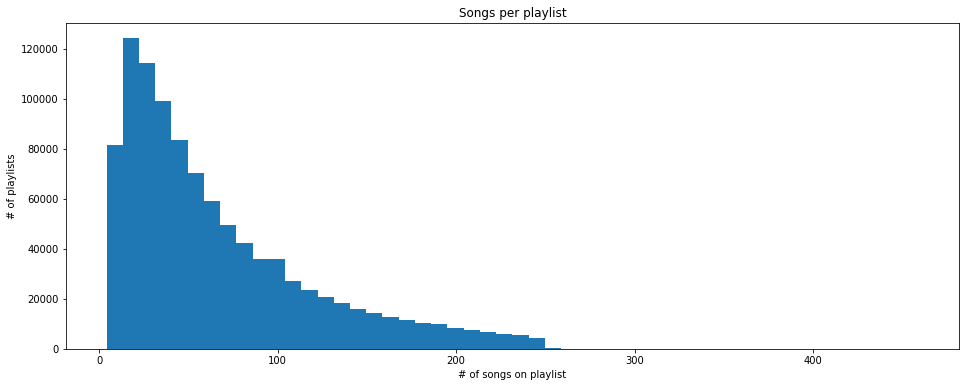

In [85]:
# plot playlist lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(songs_per_playlist_count[:, 1], bins=50);
    
ax.set_title('Songs per playlist')
ax.set_ylabel('# of playlists')
ax.set_xlabel('# of songs on playlist');

print('Smallest playlist:', np.min(songs_per_playlist_count[:, 1]))
print('Largest playlist:', np.max(songs_per_playlist_count[:, 1]))
print('Mean playlist length:', np.mean(songs_per_playlist_count[:, 1]))
print('Median playlist length:', np.median(songs_per_playlist_count[:, 1]))
print('Mode playlist length:', stats.mode(songs_per_playlist_count[:, 1])[0][0], 'songs (',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'playlists )')

Shortest avg length: -1.0
Longest avg length: 4350476.743589744
Mean avg length: 160710.60076846372
Median avg length: 220159.53846153847
Mode avg length: 0.0 ms ( 15028 playlists )


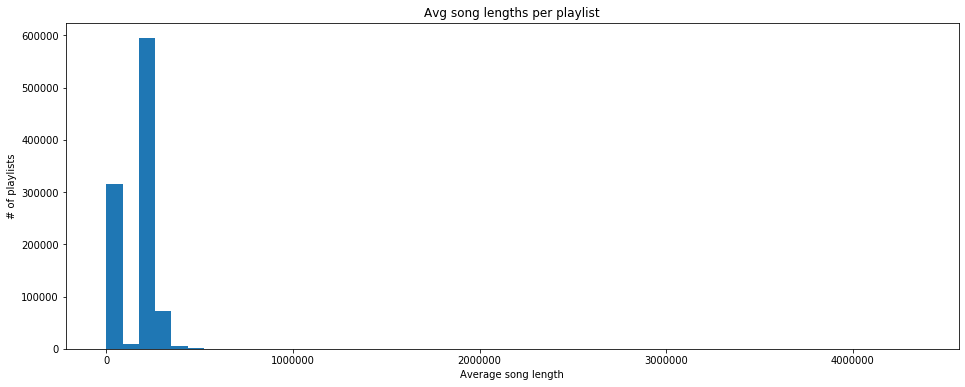

In [90]:
# plot playlist avg song lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(songs_per_playlist_avg[:, 1], bins=50);
    
ax.set_title('Avg song lengths per playlist')
ax.set_ylabel('# of playlists')
ax.set_xlabel('Average song length');

print('Shortest avg length:', np.min(songs_per_playlist_avg[:, 1]))
print('Longest avg length:', np.max(songs_per_playlist_avg[:, 1]))
print('Mean avg length:', np.mean(songs_per_playlist_avg[:, 1]))
print('Median avg length:', np.median(songs_per_playlist_avg[:, 1]))
print('Mode avg length:', stats.mode(songs_per_playlist_avg[:, 1])[0][0], 'ms (',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'playlists )')

In [91]:
# Most popular artists by playlist appearance (artist name)
artist_playlist_app_count = session.query(Playlists.artist_name, func.count(Playlists.artist_name).label('count')).group_by(Playlists.artist_name).all()

In [109]:
artist_playlist_app_count.sort(key=lambda x: x[1], reverse=True)
artist_playlist_app_count[:20]

[('Drake', 847159),
 ('Kanye West', 413291),
 ('Kendrick Lamar', 353624),
 ('Rihanna', 339548),
 ('The Weeknd', 316603),
 ('Eminem', 294667),
 ('Ed Sheeran', 272116),
 ('Future', 250734),
 ('Justin Bieber', 243119),
 ('J. Cole', 241560),
 ('Beyoncé', 230857),
 ('The Chainsmokers', 223509),
 ('Chris Brown', 212772),
 ('Calvin Harris', 203047),
 ('Twenty One Pilots', 198905),
 ('Lil Uzi Vert', 197855),
 ('Post Malone', 195907),
 ('Big Sean', 192478),
 ('Maroon 5', 187029),
 ('JAY Z', 185520)]

In [119]:
# Most popular tracks by playlist appearance (uri)
track_playlist_app_count = session.query(Playlists.artist_name, Playlists.track_name, func.count(Playlists.track_uri).label('count')).group_by(Playlists.track_uri).all()

In [121]:
track_playlist_app_count.sort(key=lambda x: x[2], reverse=True)
track_playlist_app_count[:20]

[('Kendrick Lamar', 'HUMBLE.', 46574),
 ('Drake', 'One Dance', 43447),
 ('DRAM', 'Broccoli (feat. Lil Yachty)', 41309),
 ('The Chainsmokers', 'Closer', 41079),
 ('Post Malone', 'Congratulations', 39987),
 ('Aminé', 'Caroline', 35202),
 ('KYLE', 'iSpy (feat. Lil Yachty)', 35138),
 ('Migos', 'Bad and Boujee (feat. Lil Uzi Vert)', 34999),
 ('Lil Uzi Vert', 'XO TOUR Llif3', 34922),
 ('Khalid', 'Location', 34657),
 ('Big Sean', 'Bounce Back', 33699),
 ('R. Kelly', 'Ignition - Remix', 32391),
 ('J. Cole', 'No Role Modelz', 32336),
 ('Future', 'Mask Off', 32059),
 ('Chance The Rapper', 'No Problem (feat. Lil Wayne & 2 Chainz)', 31492),
 ('DJ Khaled', "I'm the One", 31374),
 ('Drake', 'Jumpman', 31119),
 ('Travis Scott', 'goosebumps', 31106),
 ('Drake', 'Fake Love', 30678),
 ('Luis Fonsi', 'Despacito - Remix', 30485)]

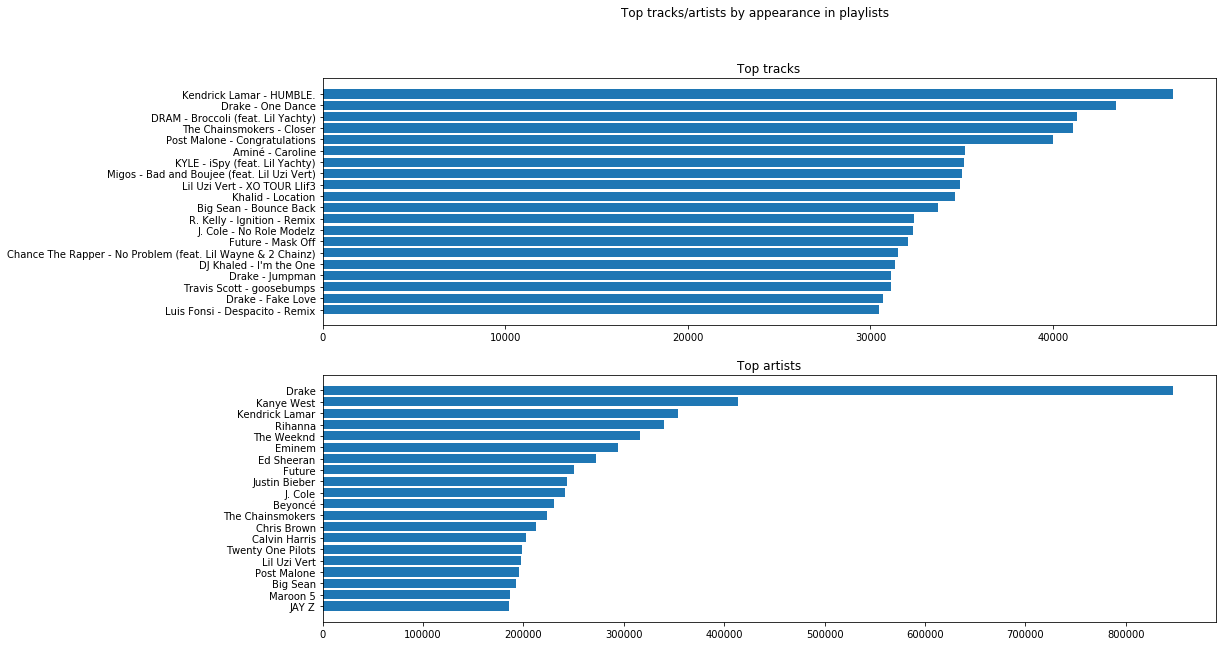

In [137]:
top20_track_counts = [x[2] for x in track_playlist_app_count[:20]]
top20_track_labels = [x[0] + ' - ' + x[1] for x in track_playlist_app_count[:20]]

top20_artist_counts = [x[1] for x in artist_playlist_app_count[:20]]
top20_artist_labels = [x[0] for x in artist_playlist_app_count[:20]]

top20_track_counts.reverse()
top20_track_labels.reverse()
top20_artist_counts.reverse()
top20_artist_labels.reverse()

# barplots for 20 most popular artists/tracks
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

y1 = np.arange(len(top20_track_counts))
y2 = np.arange(len(top20_artist_counts))
    
axs[0].barh(y1, top20_track_counts)
    
axs[0].set_title('Top tracks')
# axs[0].set_ylabel('# of playlists')
# axs[0].set_xlabel('Average song length')
axs[0].set_yticks(y1)
axs[0].set_yticklabels(top20_track_labels)

axs[1].barh(y2, top20_artist_counts)
    
axs[1].set_title('Top artists')
# axs[1].set_ylabel('# of playlists')
# axs[1].set_xlabel('Average song length')
axs[1].set_yticks(y2)
axs[1].set_yticklabels(top20_artist_labels)

fig.suptitle('Top tracks/artists by appearance in playlists');

#### Artists

In [141]:
artist_popularities = session.query(Artists.artist_popularity).all()
artist_popularities = [x[0] for x in artist_popularities] 
artist_popularities[:10]

[0, 8, 5, 40, 21, 0, 7, 37, 40, 38]

Min popularity: 0
Max popularity: 100
Average popularity: 16.3771983757525
Median popularity: 11.0
Mode popularity: 0 ( 15028 artists )


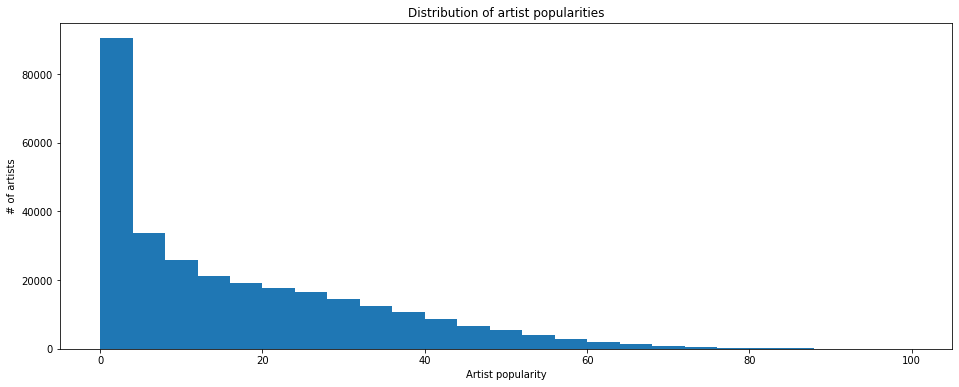

In [144]:
# plot playlist avg song lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(artist_popularities, bins=25);
    
ax.set_title('Distribution of artist popularities')
ax.set_ylabel('# of artists')
ax.set_xlabel('Artist popularity');

print('Min popularity:', np.min(artist_popularities))
print('Max popularity:', np.max(artist_popularities))
print('Average popularity:', np.mean(artist_popularities))
print('Median popularity:', np.median(artist_popularities))
print('Mode popularity:', stats.mode(artist_popularities)[0][0], '(',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'artists )')

In [158]:
artist_genres = session.query(Artists.genres, func.count(Artists.genres)).group_by(Artists.genres).all()
artist_genres.sort(key=lambda x: x[1], reverse=True)

print('TOTAL:', len(artist_genres))
print(artist_genres[:20])

TOTAL: 30167
[('', 181365), ('fake', 202), ('karaoke', 188), ('deep underground hip hop', 186), ('praise', 185), ('sleep', 181), ('indie electropop', 149), ('country pop', 145), ('relaxative', 136), ('deep pop r&b', 132), ('deep talent show', 125), ('regional mexican pop', 120), ('sky room', 119), ('deep tropical house', 118), ('vapor soul', 118), ('indie anthem-folk', 117), ('deep dubstep', 116), ('workout product', 116), ('pop reggaeton', 115), ('channel pop', 114)]


#### Tracks

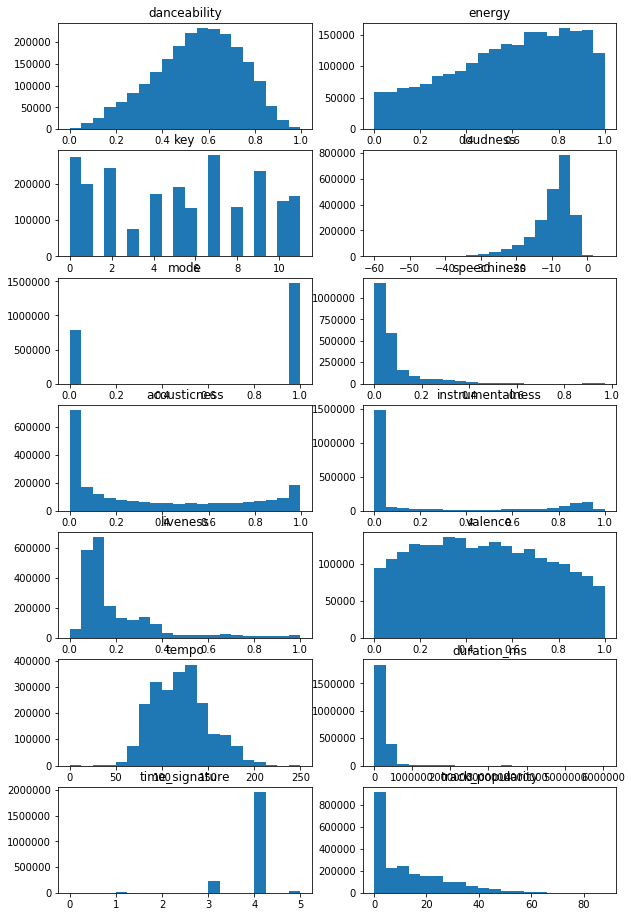

In [186]:
track_feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                      'duration_ms', 'time_signature', 'track_popularity']

# plot distributions of each track attribute
fig, axs = plt.subplots(7, 2, figsize=(16, 16))

# plot individual values by fold
for i, ax in enumerate(axs.ravel()):
    tr_feature = session.query(getattr(Tracks, track_feature_cols[i])).all()
    tr_feature = [x[0] is not None and x[0] or 0 for x in tr_feature]
    ax.hist(tr_feature, bins=20)
    ax.set_title(track_feature_cols[i]);